In [132]:
#Gerekli modüllerin import edilmesi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split


Gerekli Fonksiyonların Tanımlanması

In [133]:
#Veri setini inceleyebilmek için bir fonksiyon tanımlanması

def check_data(df,head=5):
    print("######## SHAPE ########") #Boyut bilgisi
    print(df.shape)
    print("######## TYPES ########")#Veri tipi bilgisi
    print(df.dtypes)
    print("######## HEAD ########")#İlk 5 satırı
    print(df.head(head))
    print("######## TAIL ########")#Son 5 satırı
    print(df.tail(head))
    print("######## NA ########")#Boş değer var mı?
    print(df.isnull().sum())
    print("######## DESCRIBE ########")#istatistiksel özeti
    print(df.describe())

In [134]:
#Veri seti içerisindeki değişkenleri analiz etmek için fonksiyon yazılması

def grab_col_names(df,cat_th=10,car_th=20):
    cat_cols=[col for col in df.columns if df[col].dtypes=="O"]# Tipi object olanların alınması

#Sayılsal yapıda olan değişkenlerin içerisinde 10'dan az benzersiz varsa kategorik değişken olarak alınması
    num_but_cat=[col for col in df.columns if df[col].nunique()<cat_th and df[col].dtypes!="O"]

#Kategorik yapıda olan değişkenlerin içerisinde 20'den fazla benzersiz varsa kardinal değişken olarak alınması
    cat_but_car=[col for col in df.columns if df[col].nunique()>car_th and df[col].dtypes=="O"]


#Kategorik değişkenlerin içinden kardinal değişkenlerin çıkartılması
    cat_cols=[col for col in cat_cols if col not in cat_but_car]
    cat_cols=cat_cols+num_but_cat

    #Sayısal değişkenlerin alınması
    num_cols=[col for col in df.columns if df[col].dtypes!="O"]

    #Sayısal değişkenler içinden kategorik olarak alınabileceklerin çıkarılması.
    num_cols=[col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols,cat_but_car

In [135]:
#Kategorik değişknelerin analizi için fonksiyon tanımlama

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, palette=['#572AFF',"#FF9351","#FF5733","#B385FF","#DAF7A6","#60D6A2","#5CE9FF","#FF74B1"])
        plt.xticks(rotation=45)
        plt.show()


In [136]:
#Sayısal değişkenlerin analizi için fonksiyon oluşturma

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50,  color = "indigo", ec="indigo")
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [137]:
#Hedef değişken analizi için fonksiyon oluşturma

def target_summary_with_cat(dataframe, target, num_col):
    print(pd.DataFrame({num_col: dataframe.groupby(target)[num_col].mean()}), end="\n\n Target Mean")

In [138]:
#Aykırı değer analizi için fonksiyon oluşturulması

def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


In [139]:
#Aykırı değer kontrolü yapılması

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [140]:
#Eksik değer analizi için fonksiyon oluşturulması

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [141]:
#One hot encoder işleminin yapılması

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe



Veri Ön İşleme

In [142]:
#Veriyi içe aktarma
df = pd.read_csv('train.csv')

#Fonsiyonu çalıştırıp veriyi gözlemleme

check_data(df)

######## SHAPE ########
(5460, 14)
######## TYPES ########
index                                           int64
Cinsiyet                                       object
Yaş Grubu                                      object
Medeni Durum                                   object
Eğitim Düzeyi                                  object
İstihdam Durumu                                object
Yıllık Ortalama Gelir                         float64
Yaşadığı Şehir                                 object
En Çok İlgilendiği Ürün Grubu                  object
Yıllık Ortalama Satın Alım Miktarı            float64
Yıllık Ortalama Sipariş Verilen Ürün Adedi    float64
Eğitime Devam Etme Durumu                      object
Öbek İsmi                                      object
Yıllık Ortalama Sepete Atılan Ürün Adedi      float64
dtype: object
######## HEAD ########
   index Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi  \
0      0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu   
1      1    Erke

In [143]:
#Değişken analizi fonksiyonunun çalıştırılması

cat_cols, num_cols,cat_but_car = grab_col_names(df)

Observations: 5460
Variables: 14
cat_cols: 9
num_cols: 5
cat_but_car: 0
num_but_cat: 0


          Cinsiyet      Ratio
Cinsiyet                     
Erkek         2964  54.285714
Kadın         2496  45.714286


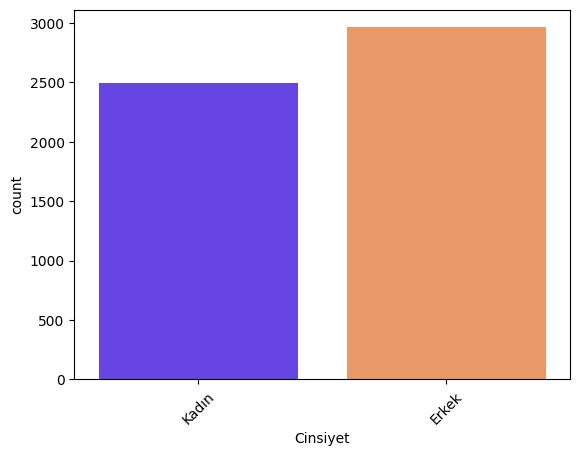

           Yaş Grubu      Ratio
Yaş Grubu                      
18-30           1841  33.717949
31-40           1477  27.051282
51-60            861  15.769231
41-50            727  13.315018
>60              554  10.146520


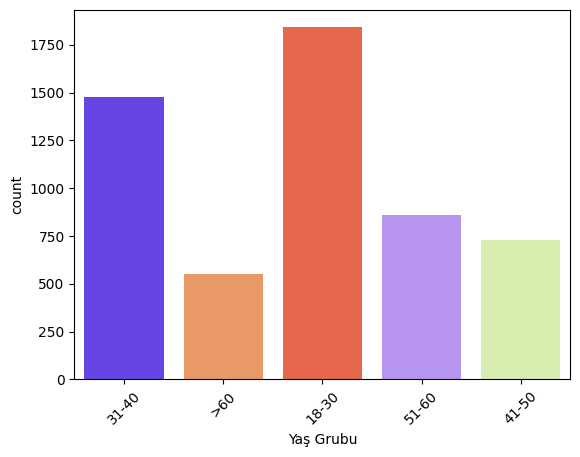

              Medeni Durum      Ratio
Medeni Durum                         
Evli                  2834  51.904762
Bekar                 2626  48.095238


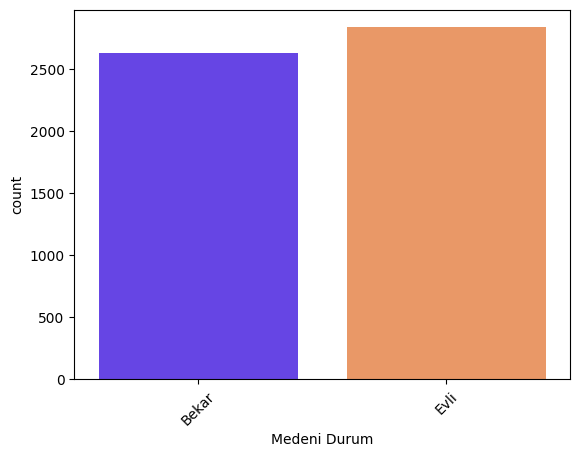

                      Eğitim Düzeyi      Ratio
Eğitim Düzeyi                                 
Lise Mezunu                    1388  25.421245
Üniversite Mezunu              1257  23.021978
Yüksekokul Mezunu               588  10.769231
Yüksek Lisans Mezunu            545   9.981685
İlkokul Mezunu                  417   7.637363
Ortaokul Mezunu                 412   7.545788
Eğitimsiz                       381   6.978022
Doktora Mezunu                  263   4.816850
Doktora Ötesi                   209   3.827839


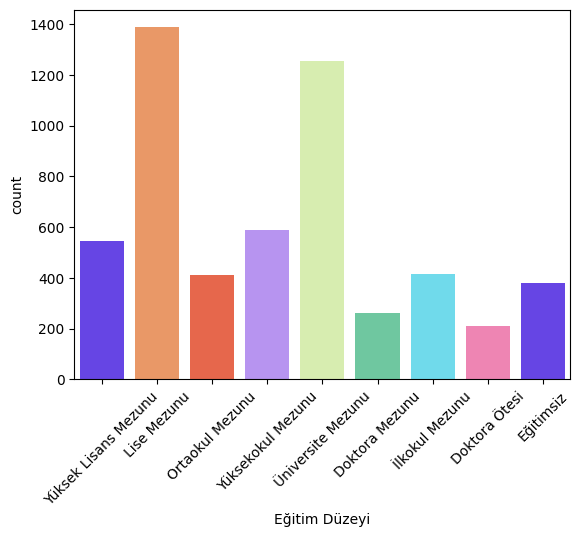

                                İstihdam Durumu      Ratio
İstihdam Durumu                                           
Düzenli ve Ücretli Bir İşi Var             2768  50.695971
İşsiz veya Düzenli Bir İşi Yok             1349  24.706960
Kendi İşinin Sahibi                         879  16.098901
Emekli                                      464   8.498168


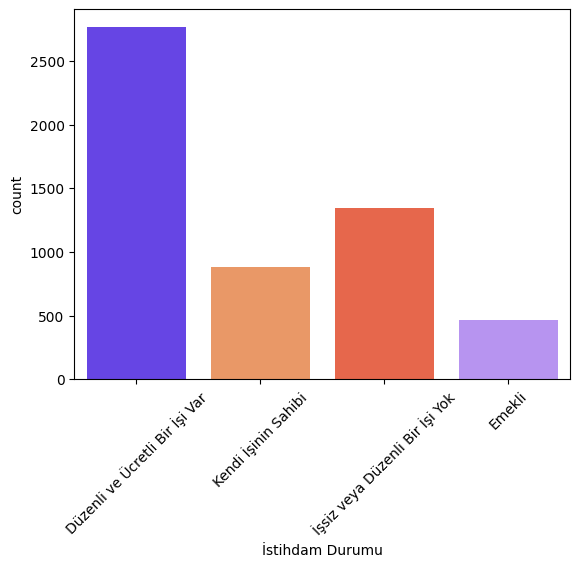

                 Yaşadığı Şehir      Ratio
Yaşadığı Şehir                            
Büyük Şehir                1959  35.879121
Küçük Şehir                1842  33.736264
Köy veya Kasaba            1092  20.000000
Kırsal                      567  10.384615


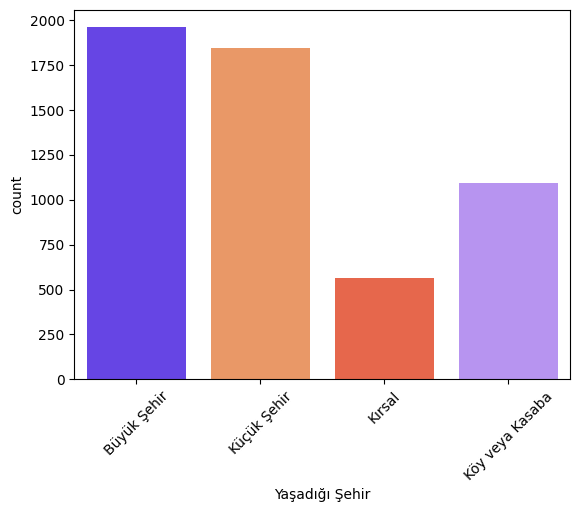

                                  En Çok İlgilendiği Ürün Grubu      Ratio
En Çok İlgilendiği Ürün Grubu                                             
Giyim                                                      1487  27.234432
Ev ve Mobilya                                              1114  20.402930
Elektronik ve Teknolojik Ürünler                           1029  18.846154
Spor Malzemeleri                                           1001  18.333333
Kozmetik                                                    829  15.183150


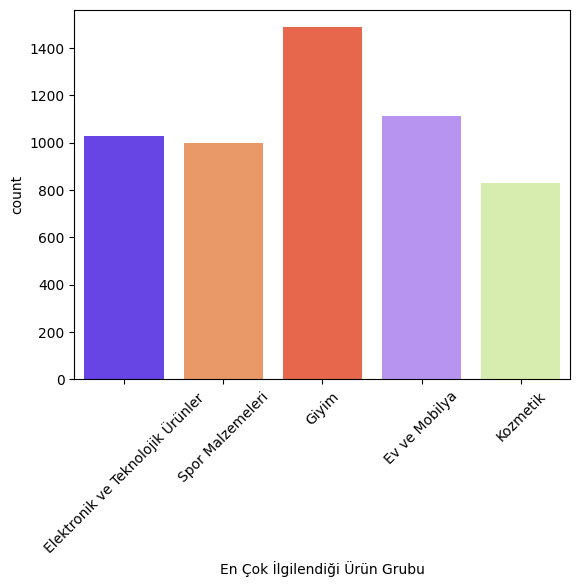

                           Eğitime Devam Etme Durumu      Ratio
Eğitime Devam Etme Durumu                                      
Etmiyor                                         4554  83.406593
Ediyor                                           906  16.593407


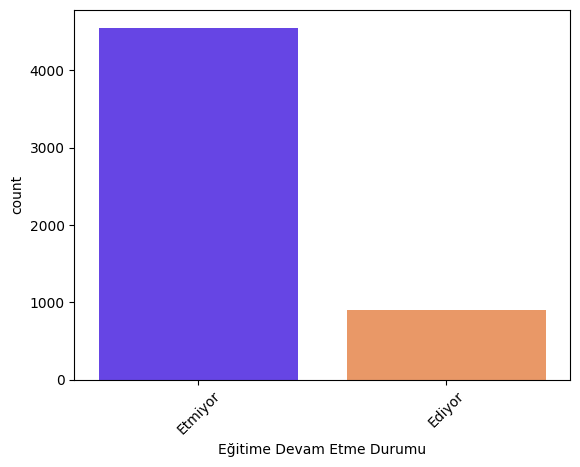

           Öbek İsmi      Ratio
Öbek İsmi                      
obek_4           720  13.186813
obek_8           717  13.131868
obek_5           706  12.930403
obek_3           695  12.728938
obek_7           695  12.728938
obek_1           692  12.673993
obek_6           688  12.600733
obek_2           547  10.018315


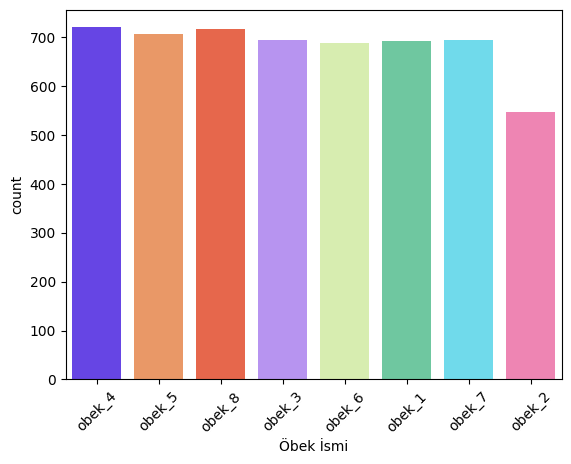

In [144]:
#KATEGORİK DEĞİŞKEN ANALİZİ#


for col in cat_cols:
    cat_summary(df, col, plot=True)

count    5460.000000
mean     2729.500000
std      1576.310566
min         0.000000
5%        272.950000
10%       545.900000
20%      1091.800000
30%      1637.700000
40%      2183.600000
50%      2729.500000
60%      3275.400000
70%      3821.300000
80%      4367.200000
90%      4913.100000
95%      5186.050000
99%      5404.410000
max      5459.000000
Name: index, dtype: float64


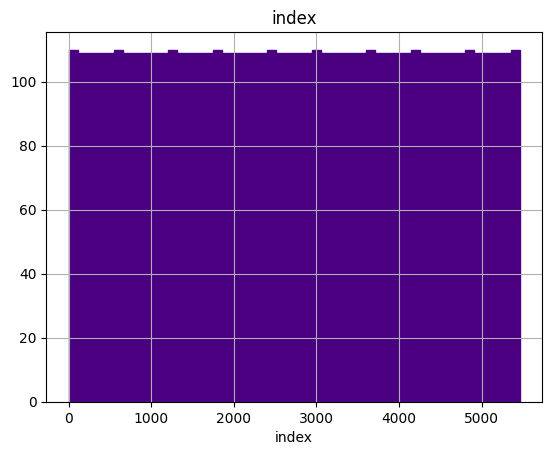

count    5.460000e+03
mean     3.635711e+05
std      2.197144e+05
min      4.392299e+04
5%       1.506287e+05
10%      1.705754e+05
20%      2.032899e+05
30%      2.274463e+05
40%      2.517758e+05
50%      2.869254e+05
60%      3.438221e+05
70%      3.727974e+05
80%      4.842462e+05
90%      7.590807e+05
95%      8.908845e+05
99%      1.035737e+06
max      1.192437e+06
Name: Yıllık Ortalama Gelir, dtype: float64


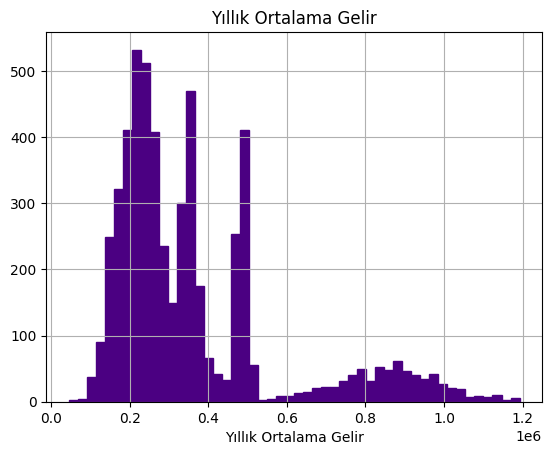

count     5460.000000
mean     16616.612217
std      14099.171704
min       2859.254000
5%        3750.944992
10%       3982.074933
20%       4480.098785
30%       5443.628646
40%       6530.204868
50%       8426.818967
60%       9649.438113
70%      27959.771488
80%      33290.270684
90%      38756.728396
95%      41256.719718
99%      44022.409246
max      48605.594415
Name: Yıllık Ortalama Satın Alım Miktarı, dtype: float64


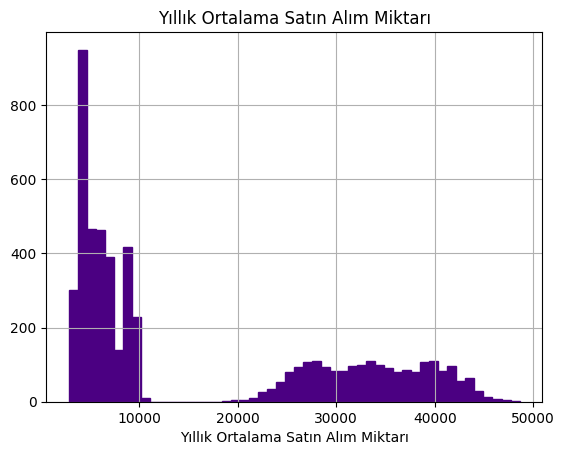

count    5460.000000
mean       24.040884
std        14.945655
min         0.000000
5%          4.012480
10%         7.169551
20%        10.321560
30%        14.277608
40%        16.356228
50%        20.095924
60%        26.176960
70%        31.195390
80%        39.760832
90%        46.698859
95%        51.775273
99%        57.663604
max        64.616196
Name: Yıllık Ortalama Sipariş Verilen Ürün Adedi, dtype: float64


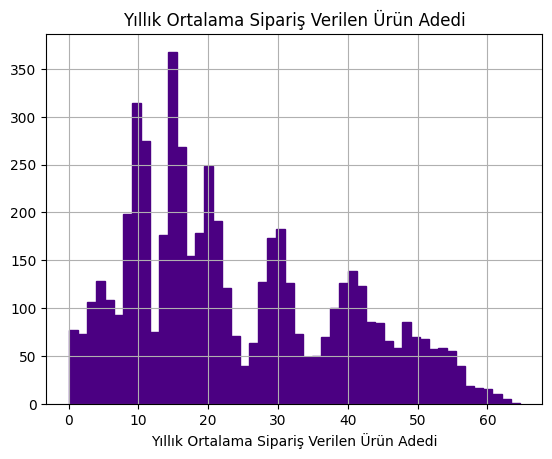

count    5460.000000
mean       73.445693
std        47.214184
min         3.977559
5%          9.478686
10%        11.471611
20%        20.334653
30%        43.406962
40%        51.719672
50%        82.485579
60%        94.814793
70%       101.236289
80%       108.553175
90%       129.625888
95%       159.470950
99%       192.469370
max       242.308441
Name: Yıllık Ortalama Sepete Atılan Ürün Adedi, dtype: float64


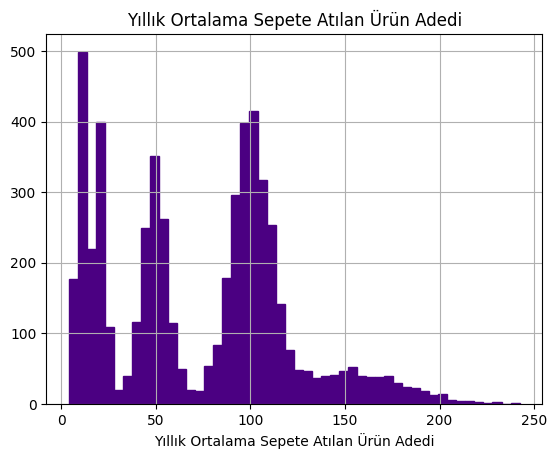

In [145]:
#Sayısal değişkenlerin analizi için fonskiyonun çağrılması

for col in num_cols:
    num_summary(df, col, True)

In [146]:
#Hedef değişken analizi için fonskiyonun çağrılması

for col in num_cols:
    target_summary_with_cat(df,"Öbek İsmi",col)

                 index
Öbek İsmi             
obek_1     2735.617052
obek_2     2683.287020
obek_3     2750.192806
obek_4     2807.161111
obek_5     2656.369688
obek_6     2757.139535
obek_7     2739.153957
obek_8     2696.937238

 Target Mean           Yıllık Ortalama Gelir
Öbek İsmi                       
obek_1             229513.847974
obek_2             172827.509911
obek_3             327899.094458
obek_4             817975.516312
obek_5             222224.036354
obek_6             480117.776102
obek_7             351949.976050
obek_8             255354.926670

 Target Mean           Yıllık Ortalama Satın Alım Miktarı
Öbek İsmi                                    
obek_1                            6047.195827
obek_2                            4996.038895
obek_3                            7360.697229
obek_4                           32405.008963
obek_5                            4542.305314
obek_6                           39440.273682
obek_7                           26429.293943


In [147]:

#Aykırı değer analizi
for col in num_cols:
      print(col, check_outlier(df, col))



index False
Yıllık Ortalama Gelir False
Yıllık Ortalama Satın Alım Miktarı False
Yıllık Ortalama Sipariş Verilen Ürün Adedi False
Yıllık Ortalama Sepete Atılan Ürün Adedi False


In [148]:
#Eksik değer analizi

missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [149]:
#Encoding İşlemleri
#Ordinal olan kategorik verilerin nümerik hale getirilmesi
sozluk = {
    "obek_1":0,
    "obek_2":1,
    "obek_3":2,
    "obek_4":3,
    "obek_5":4,
    "obek_6":5,
    "obek_7":6,
    "obek_8":7
}
df["Öbek İsmi"] = df["Öbek İsmi"].map(sozluk)


sozluk2 = {

      'Eğitimsiz':1,
      'İlkokul Mezunu':2,
      'Ortaokul Mezunu':3,
      'Lise Mezunu':4,
      'Yüksekokul Mezunu': 5,
      'Üniversite Mezunu':6,
      'Yüksek Lisans Mezunu':7,
      'Doktora Mezunu':8,
      'Doktora Ötesi':9
}
df["Eğitim Düzeyi"] = df["Eğitim Düzeyi"].map(sozluk2)


sozluk3 = {

     'Kadın':0,
     'Erkek':1
}
df["Cinsiyet"] = df["Cinsiyet"].map(sozluk3)


sozluk4 = {

     '18-30':1,
     '31-40':2,
     '41-50':3,
     '51-60':4,
     '>60':5

}
df["Yaş Grubu"] = df["Yaş Grubu"].map(sozluk4)


sozluk5 = {

     'Bekar':0,
     'Evli':1
}
df["Medeni Durum"] = df["Medeni Durum"].map(sozluk5)


sozluk6 = {

     'İşsiz veya Düzenli Bir İşi Yok':1,
     'Emekli':2,
     'Düzenli ve Ücretli Bir İşi Var':3,
     'Kendi İşinin Sahibi':4
}
df["İstihdam Durumu"] = df["İstihdam Durumu"].map(sozluk6)

sozluk7 = {

     'Kırsal':1,
     'Köy veya Kasaba':2,
     'Küçük Şehir':3,
     'Büyük Şehir':4
}
df["Yaşadığı Şehir"] = df["Yaşadığı Şehir"].map(sozluk7)

sozluk8 = {

     'Etmiyor':0,
     'Ediyor':1,
}
df["Eğitime Devam Etme Durumu"] = df["Eğitime Devam Etme Durumu"].map(sozluk8)




In [150]:
#Nominal olan kategorik değişkenin nümerik hale getirilmesi
liste1 = ['En Çok İlgilendiği Ürün Grubu']

df = one_hot_encoder(df, liste1, drop_first=True)

In [151]:
#Yeni değişkenlerin oluşturulması
df["Eğitim Düzeyine Göre Aylık Gelir"] = (df["Yıllık Ortalama Gelir"] /12) * df["Eğitim Düzeyi"]
df["Satın Alım Oranı"] =  df["Yıllık Ortalama Gelir"] /  df["Yıllık Ortalama Satın Alım Miktarı"]
df["Ürün Alım Oranı"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / df["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
df["Şehre Göre Alım Miktarı"] = df["Yıllık Ortalama Satın Alım Miktarı"] * df["Yaşadığı Şehir"]
df["Eğitime Göre İstihdam"] = df["Eğitim Düzeyi"] * df["İstihdam Durumu"]
df["Yaşa Göre Alım Oranı"] =  df["Yaş Grubu"] / df["Yıllık Ortalama Satın Alım Miktarı"]
df["Gelire Göre Alım Oranı"] =  df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] /df["Yıllık Ortalama Gelir"]
df["Cinsiyete Göre Yıılık Ortalama Satın Alım"] = (df["Cinsiyet"]+1) / df["Yıllık Ortalama Satın Alım Miktarı"]
df["Aylık Maaş"] = df["Yıllık Ortalama Gelir"] /12
df["Aylık Ortalama Sepete Miktarı"] = df["Yıllık Ortalama Sepete Atılan Ürün Adedi"] /12
df["Aylık Ortalama Sipraiş Adedi"] = df["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / 12
df["Aylık Ortalama Satım Alım Miktarı"] = df["Yıllık Ortalama Satın Alım Miktarı"] / 12
df["Yaşa Göre Gelir"] = df["Yıllık Ortalama Gelir"] / (df["Yaş Grubu"])
df["İstihdama Göre Gelir"] = df["Yıllık Ortalama Gelir"] / df["İstihdam Durumu"]
df["Yaş ve Eğitim İlişkisi"] = (df["Yaş Grubu"]) * df["İstihdam Durumu"]

In [152]:
#İndekx kolonunun veriden çıkarılması ve bağımlı değişenin veriden ayrıştırılması
y = df["Öbek İsmi"]
df = df.drop(["index","Öbek İsmi"],axis=1)

In [153]:
#Korelasyonu yüksek değerlerin veriden çıkarılması 

correlation_matrix = df.corr()
threshold = 0.8 
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

df_filtered = df.drop(columns=high_corr_features)


In [154]:
# Min-Max Normalizasyonu kullanarak verinin normalize edilmesi
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df_filtered)

# Normalleştirilmiş veriyinin DataFrame'e dönüştürülmesi
X_normalized = pd.DataFrame(X_normalized, columns=df_filtered.columns)

In [155]:
#df_normalized = np.ascontiguousarray(df_normalized)
# Verinin eğitim ve test verisi olarak bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Modellerin ve isimlerinin bir liste içinde saklanması
models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (SVC(), "SVM"),
    (KNeighborsClassifier(n_neighbors=9,weights="distance"), "KNN"),
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
]

# Her model için döngünün çalıştırılması
for model, model_name in models:
    model.fit(X_train, y_train)  # Modelin eğitilmesi
    predictions = model.predict(X_test)  
    accuracy = accuracy_score(y_test, predictions)  # Her model için doğruluk değerinin hesaplanması
    print(f"{model_name} Accuracy: {accuracy}")

Random Forest Accuracy: 0.9615384615384616
SVM Accuracy: 0.9532967032967034
KNN Accuracy: 0.8974358974358975
Logistic Regression Accuracy: 0.9505494505494505


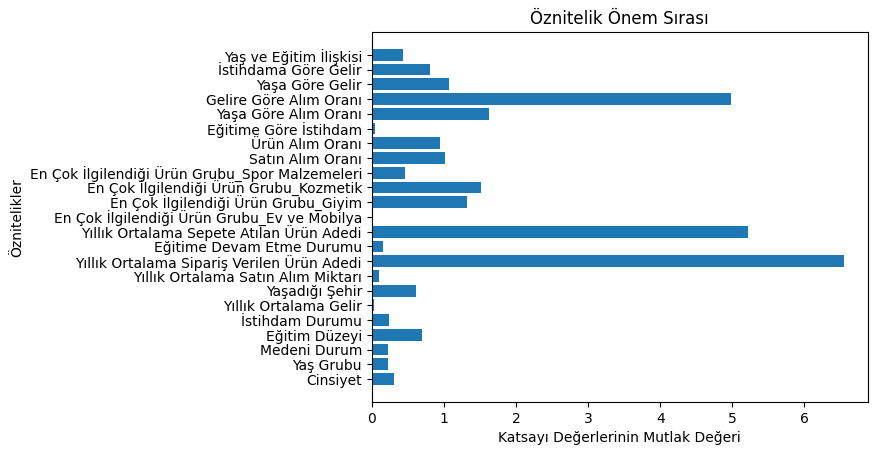

In [156]:
# Öznitelik önem sıralamasını gösteren çubuk grafiğinin çizilmesi
coefficients = np.abs(model.coef_[0])
feature_names = X_normalized.columns
plt.barh(feature_names, coefficients)
plt.xlabel('Katsayı Değerlerinin Mutlak Değeri')
plt.ylabel('Öznitelikler')
plt.title('Öznitelik Önem Sırası')
plt.show()

In [157]:

#En iyi doğruluk oranı veren Random Forest algoritmasının hiperparametre optimizasyonunun yapılması
forest_model = RandomForestClassifier()

# Optimizasyon için değer aralıklarının belirlenmesi
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV ile hiperparametre optimizasyonunun yapılması
grid_search = GridSearchCV(estimator=forest_model, param_grid=params, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi sonucun yazdırılması
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk:", grid_search.best_score_)

# Test verisi üzerinde modelin değerlendirilmesi
best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test doğruluğu:", test_accuracy)


En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
En iyi doğruluk: 0.9530677655677655
Test doğruluğu: 0.9615384615384616


In [158]:
#Modelin son halinin yeni hiperparametrelerle oluşturulması

model_forest = RandomForestClassifier(n_estimators=150,max_depth=20,min_samples_leaf=1,min_samples_split=10)


In [159]:
#Test verisine yeni kolonların eklenmesi ve normalize edilerek tahmin işlemine hazır hale getirilmesi

test = pd.read_csv("test_x.csv")

sozluk2 = {

      'Eğitimsiz':1,
      'İlkokul Mezunu':2,
      'Ortaokul Mezunu':3,
      'Lise Mezunu':4,
      'Yüksekokul Mezunu': 5,
      'Üniversite Mezunu':6,
      'Yüksek Lisans Mezunu':7,
      'Doktora Mezunu':8,
      'Doktora Ötesi':9
}
test["Eğitim Düzeyi"] = test["Eğitim Düzeyi"].map(sozluk2)


sozluk3 = {

     'Kadın':0,
     'Erkek':1
}
test["Cinsiyet"] = test["Cinsiyet"].map(sozluk3)


sozluk4 = {

     '18-30':1,
     '31-40':2,
     '41-50':3,
     '51-60':4,
     '>60':5

}
test["Yaş Grubu"] = test["Yaş Grubu"].map(sozluk4)


sozluk5 = {

     'Bekar':0,
     'Evli':1
}
test["Medeni Durum"] = test["Medeni Durum"].map(sozluk5)


sozluk6 = {

     'İşsiz veya Düzenli Bir İşi Yok':1,
     'Emekli':2,
     'Düzenli ve Ücretli Bir İşi Var':3,
     'Kendi İşinin Sahibi':4
}
test["İstihdam Durumu"] = test["İstihdam Durumu"].map(sozluk6)

sozluk7 = {

     'Kırsal':1,
     'Köy veya Kasaba':2,
     'Küçük Şehir':3,
     'Büyük Şehir':4
}
test["Yaşadığı Şehir"] = test["Yaşadığı Şehir"].map(sozluk7)

sozluk8 = {

     'Etmiyor':0,
     'Ediyor':1,
}
test["Eğitime Devam Etme Durumu"] = test["Eğitime Devam Etme Durumu"].map(sozluk8)

test = one_hot_encoder(test, ["En Çok İlgilendiği Ürün Grubu"], drop_first=True)
test = test.drop("index",axis=1)

In [160]:
#Yeni değişken oluşturma işleminin test verisine de uygulanması

test["Eğitim Düzeyine Göre Aylık Gelir"] = (test["Yıllık Ortalama Gelir"] /12) * test["Eğitim Düzeyi"]
test["Satın Alım Oranı"] =  test["Yıllık Ortalama Gelir"] /  test["Yıllık Ortalama Satın Alım Miktarı"]
test["Ürün Alım Oranı"] = test["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / test["Yıllık Ortalama Sepete Atılan Ürün Adedi"]
test["Şehre Göre Alım Miktarı"] = test["Yıllık Ortalama Satın Alım Miktarı"] * test["Yaşadığı Şehir"]
test["Eğitime Göre İstihdam"] = test["Eğitim Düzeyi"] * test["İstihdam Durumu"]
test["Yaşa Göre Alım Oranı"] =  test["Yaş Grubu"] / test["Yıllık Ortalama Satın Alım Miktarı"]
test["Gelire Göre Alım Oranı"] =  test["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] /test["Yıllık Ortalama Gelir"]
test["Cinsiyete Göre Yıılık Ortalama Satın Alım"] = (test["Cinsiyet"]+1) / test["Yıllık Ortalama Satın Alım Miktarı"]
test["Aylık Maaş"] = test["Yıllık Ortalama Gelir"] /12
test["Aylık Ortalama Sepete Miktarı"] = test["Yıllık Ortalama Sepete Atılan Ürün Adedi"] /12
test["Aylık Ortalama Sipraiş Adedi"] = test["Yıllık Ortalama Sipariş Verilen Ürün Adedi"] / 12
test["Aylık Ortalama Satım Alım Miktarı"] = test["Yıllık Ortalama Satın Alım Miktarı"] / 12
test["Yaşa Göre Gelir"] = test["Yıllık Ortalama Gelir"] / (test["Yaş Grubu"])
test["İstihdama Göre Gelir"] = test["Yıllık Ortalama Gelir"] / test["İstihdam Durumu"]
test["Yaş ve Eğitim İlişkisi"] = (test["Yaş Grubu"]) * test["İstihdam Durumu"]

#Korelasyonu yüksek olan değişkenlerin test verisinden de çıkarılması
liste = []
for i in test.columns:
    if i not in df_filtered.columns:
        liste.append(i)
    else:
        continue
test = test.drop(liste,axis=1)

In [161]:
#Test verisinin normalize edilmesi
y_normalized = scaler.fit_transform(test)

# Normalleştirilmiş veriyinin DataFrame'e dönüştürülmesi
y_normalized = pd.DataFrame(y_normalized, columns=test.columns)

In [162]:
#modelin fit edilmesi ve test verisi üzerinden tahmin yapılması
model_forest.fit(X_normalized,y)
pred = model_forest.predict(y_normalized)

In [163]:
#tahminlerin submission için uygun hale getirilmesi
y_tahmin = pd.DataFrame(pred)
sozluk2 = {
        0:"obek_1",
        1:"obek_2",
        2:"obek_3",
        3:"obek_4",
        4:"obek_5",
        5:"obek_6",
        6:"obek_7",
        7:"obek_8",
        }
y_tahmin
y_tahmin = y_tahmin[0].map(sozluk2)
y_tahmin = pd.DataFrame(y_tahmin)
y_tahmin.insert(0, 'id', y_tahmin.index)
y_tahmin.rename(columns={0: "Öbek İsmi"}, inplace=True)
y_tahmin.to_csv("tahmin.csv",index=False)